# 1. Proyek Analisis Sentimen - Playstore
Notebook ini mencakup seluruh tahapan proyek analisis sentimen terhadap data Kometar pada game GenshinImpact. Termasuk:
- Pemuatan dan eksplorasi data
- Pembersihan dan pra-pemrosesan teks
- Pelabelan sentimen
- Ekstraksi fitur
- Pelatihan model ML
- Evaluasi performa
- Inference (pengujian input baru)

untuk proses scraping saya menggunakan script scrape.py dan hasilnya di simpan pada file data_playstore.csv

In [41]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IMM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Preprocessing dan Pelabelan Data
a. Baca dataset:

In [2]:
import pandas as pd

# Memuat dataset dari file CSV
df = pd.read_csv("data_playstore.csv")

# Menampilkan 10 baris pertama untuk mengecek data
df.head(10)


,userName,at,content
0,Pengguna Google,2025-05-10 14:36:04,lumayan waktu
1,Pengguna Google,2025-05-08 20:47:40,makasih ghensin dulu 2020 gua masih pake hp ke...
2,Pengguna Google,2025-05-07 19:07:39,yang aku mau la chanson malah dapat qiqi kalo ...
3,Pengguna Google,2025-05-07 05:53:39,game best kalo bisa main 😁
4,Pengguna Google,2025-05-06 20:11:07,Genshin Impact Grafik HD Fps 60 Karakter baru ...
5,Pengguna Google,2025-05-05 16:23:28,"Kenapa akun saya tiba tiba tidak bisa log in, ..."
6,Pengguna Google,2025-04-16 05:01:17,"udh game kikir,,game yapping,,muka NPC nya tem..."
7,Pengguna Google,2025-04-15 17:28:21,"ayolah jangan jean, aku mau xilonen, udh cape ..."
8,Pengguna Google,2025-04-15 17:12:35,Jangan Main game dev mihoyo buat kesehatan men...
9,Pengguna Google,2025-04-15 15:55:50,"Game Kikir, gacha Ampas"



b. Cek isi dan kolom:

In [3]:
df.head()
# Cek info dan kolom data
df.info()

# Cek distribusi data pada kolom 'content'
df['content'].head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  3000 non-null   object
 1   at        3000 non-null   object
 2   content   3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


0                                        lumayan waktu
1    makasih ghensin dulu 2020 gua masih pake hp ke...
2    yang aku mau la chanson malah dapat qiqi kalo ...
3                           game best kalo bisa main 😁
4    Genshin Impact Grafik HD Fps 60 Karakter baru ...
Name: content, dtype: object


c. Buat label sentimen:

In [8]:
import pandas as pd
from textblob import TextBlob

# Memuat data
df = pd.read_csv("data_playstore.csv")

# Cek isi file
df.head()

# Fungsi untuk menentukan sentimen dari teks
def label_sentiment(text):
    # Analisis sentimen menggunakan TextBlob
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity  # Nilai polaritas antara -1 (negatif) dan 1 (positif)

    if polarity > 0.1:
        return 'positif'
    elif polarity < -0.1:
        return 'negatif'
    else:
        return 'netral'

# Terapkan label_sentiment ke kolom 'content'
df['sentiment'] = df['content'].apply(label_sentiment)

# Tampilkan hasil
df.head()


,userName,at,content,sentiment
0,Pengguna Google,2025-05-10 14:36:04,lumayan waktu,netral
1,Pengguna Google,2025-05-08 20:47:40,makasih ghensin dulu 2020 gua masih pake hp ke...,netral
2,Pengguna Google,2025-05-07 19:07:39,yang aku mau la chanson malah dapat qiqi kalo ...,netral
3,Pengguna Google,2025-05-07 05:53:39,game best kalo bisa main 😁,positif
4,Pengguna Google,2025-05-06 20:11:07,Genshin Impact Grafik HD Fps 60 Karakter baru ...,netral


# 3. Ekstraksi Fitur
Ubah content menjadi vektor teks.

a. TF-IDF:

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Memuat data
df = pd.read_csv("data_playstore.csv")

# Pastikan kolom sentiment sudah ada
df['sentiment'] = df['content'].apply(label_sentiment)

# Ekstraksi fitur menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['content'].astype(str)).toarray()

# Target variabel (label sentimen)
y = df['sentiment']

# Tampilkan bentuk matriks fitur
print(X.shape)  # Menampilkan jumlah fitur yang dihasilkan

# Contoh melihat beberapa fitur (kata-kata)
print(tfidf.get_feature_names_out()[:10])  # Menampilkan 10 fitur pertama


(3000, 5000)
['00' '000' '01' '10' '100' '1000' '10000' '100000000' '1000000000'
 '10034']


# 4. Split Data

In [11]:
from sklearn.model_selection import train_test_split

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan ukuran data training dan testing
print("Ukuran data training:", X_train.shape)
print("Ukuran data testing:", X_test.shape)


Ukuran data training: (2400, 5000)
Ukuran data testing: (600, 5000)


# 5. Pelatihan Model
Lakukan minimal 3 skema berbeda. Contoh:

a. Skema 1: Random Forest + TF-IDF

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Skema 1: Random Forest + TF-IDF

# Inisialisasi model Random Forest
model_rf = RandomForestClassifier()

# Melatih model dengan data latih
model_rf.fit(X_train, y_train)

# Prediksi dengan data uji
y_pred_rf = model_rf.predict(X_test)

# Evaluasi model
print("Akurasi Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Classification Report Random Forest:")
print(classification_report(y_test, y_pred_rf))


Akurasi Random Forest: 0.8966666666666666
Classification Report Random Forest:
              precision    recall  f1-score   support

     negatif       0.87      0.95      0.91       154
      netral       0.90      0.94      0.92       371
     positif       0.96      0.57      0.72        75

    accuracy                           0.90       600
   macro avg       0.91      0.82      0.85       600
weighted avg       0.90      0.90      0.89       600



In [16]:
#Penjelasan:
#- RandomForestClassifier(): Model klasifikasi yang menggunakan algoritma Random Forest.
#- model_rf.fit(X_train, y_train): Melatih model dengan data latih.
#- model_rf.predict(X_test): Memprediksi hasil untuk data uji.
#- accuracy_score(y_test, y_pred_rf): Menghitung akurasi model.
#- classification_report(y_test, y_pred_rf): Menampilkan laporan klasifikasi, termasuk precision, recall, dan F1-score.

b. Skema 2: Logistic Regression + TF-IDF:

In [17]:
from sklearn.linear_model import LogisticRegression

# Skema 2: Logistic Regression + TF-IDF

# Inisialisasi model Logistic Regression
model_lr = LogisticRegression()

# Melatih model dengan data latih
model_lr.fit(X_train, y_train)

# Prediksi dengan data uji
y_pred_lr = model_lr.predict(X_test)

# Evaluasi model
print("Akurasi Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print("Classification Report Logistic Regression:")
print(classification_report(y_test, y_pred_lr))


Akurasi Logistic Regression: 0.845
Classification Report Logistic Regression:
              precision    recall  f1-score   support

     negatif       0.88      0.79      0.83       154
      netral       0.83      0.95      0.88       371
     positif       0.92      0.44      0.59        75

    accuracy                           0.84       600
   macro avg       0.88      0.73      0.77       600
weighted avg       0.85      0.84      0.83       600



c. Skema 3: Support Vector Machine (SVM) + TF-IDF:

In [18]:
from sklearn.svm import SVC

# Skema 3: SVM + TF-IDF

# Inisialisasi model SVM
model_svm = SVC()

# Melatih model dengan data latih
model_svm.fit(X_train, y_train)

# Prediksi dengan data uji
y_pred_svm = model_svm.predict(X_test)

# Evaluasi model
print("Akurasi SVM:", accuracy_score(y_test, y_pred_svm))
print("Classification Report SVM:")
print(classification_report(y_test, y_pred_svm))


Akurasi SVM: 0.8616666666666667
Classification Report SVM:
              precision    recall  f1-score   support

     negatif       0.89      0.82      0.86       154
      netral       0.84      0.96      0.90       371
     positif       1.00      0.44      0.61        75

    accuracy                           0.86       600
   macro avg       0.91      0.74      0.79       600
weighted avg       0.87      0.86      0.85       600



# 6. Inference dan Output
Tambahkan cell inference:

In [19]:
# Contoh inference pada data baru
sample_text = ["game best kalo bisa main 😁", "lumayan waktu"]

# Ubah sample_text menjadi vektor TF-IDF
sample_vec = tfidf.transform(sample_text)

# Prediksi sentimen menggunakan model Random Forest
predicted_labels = model_rf.predict(sample_vec)

# Tampilkan hasil prediksi
for text, label in zip(sample_text, predicted_labels):
    print(f"Teks: {text} --> Sentimen: {label}")


Teks: game best kalo bisa main 😁 --> Sentimen: positif
Teks: lumayan waktu --> Sentimen: netral


In [21]:
#Penjelasan:
#- sample_text: daftar kalimat baru yang ingin Anda prediksi sentimennya.
#- tfidf.transform(): mengubah teks baru menjadi bentuk vektor sesuai model TF-IDF yang sudah dilatih.
#- model_rf.predict(): memprediksi label sentimen berdasarkan vektor input.
#- zip() digunakan untuk mencocokkan teks dan hasil prediksi agar output lebih mudah dibaca.

# 7. Visualisasi Distribusi Label Sentimen


C:\Users\IMM\AppData\Local\Temp\ipykernel_34204\3293345840.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='Set2')


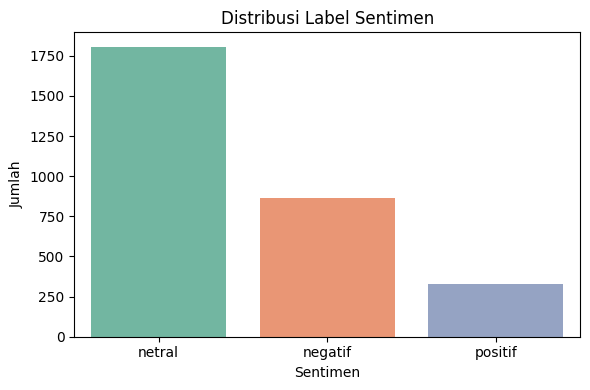

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribusi label sentimen
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='Set2')
plt.title("Distribusi Label Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()
